<a href="https://colab.research.google.com/github/HaripriyaVennam/Neural-Networks-and-Deep-Learning/blob/main/exam1/Untitled8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin


In [2]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data to be in the range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Define number of classes
num_classes = 10


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [3]:
from tensorflow.keras.layers import Input

# Function to create the CNN model
def create_cnn_model(optimizer='adam', learning_rate=0.001):
    model = Sequential([
        Input(shape=(32, 32, 3)),  # Specify input shape using the Input layer
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [12]:
class KerasModelWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, optimizer='adam', learning_rate=0.001):
        self.optimizer = optimizer
        self.learning_rate = learning_rate

    def fit(self, X, y, **kwargs):  # <-- Accept extra Keras arguments
        self.model = create_cnn_model(self.optimizer, self.learning_rate)
        self.model.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=-1)

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]  # Return accuracy

# Wrapper for GridSearchCV
model = KerasModelWrapper()


In [13]:
param_grid = {
    'optimizer': [Adam, SGD],
    'learning_rate': [0.001, 0.01],
}


In [14]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'optimizer': [Adam],  # Start with just Adam optimizer for faster testing
    'learning_rate': [0.001, 0.01],  # Smaller set of learning rates
}

# Use RandomizedSearchCV for faster search (less exhaustive)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=2, cv=2, n_jobs=-1, verbose=1, random_state=42)
random_search_result = random_search.fit(x_train, y_train)

# Best Parameters from Randomized Search
print(f"Best Parameters: {random_search_result.best_params_}")
print(f"Best Validation Accuracy: {random_search_result.best_score_}")

# Get the best model
best_model = random_search_result.best_estimator_


Fitting 2 folds for each of 2 candidates, totalling 4 fits
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.2531 - loss: 1.9709
Best Parameters: {'optimizer': <class 'keras.src.optimizers.adam.Adam'>, 'learning_rate': 0.001}
Best Validation Accuracy: 0.40967999398708344


In [15]:
# Callback for ReduceLROnPlateau to reduce learning rate based on validation loss
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Fit the best model with the callback
history = best_model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), callbacks=[reduce_lr])


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.2407 - loss: 2.0094 - val_accuracy: 0.4953 - val_loss: 1.3709 - learning_rate: 0.0010
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4615 - loss: 1.4693 - val_accuracy: 0.5599 - val_loss: 1.2319 - learning_rate: 0.0010
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5292 - loss: 1.3115 - val_accuracy: 0.5986 - val_loss: 1.1222 - learning_rate: 0.0010
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5740 - loss: 1.2069 - val_accuracy: 0.6249 - val_loss: 1.0688 - learning_rate: 0.0010
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6088 - loss: 1.1160 - val_accuracy: 0.6539 - val_loss: 0.9802 - learning_rate: 0.0010
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6361 - loss: 1.0460 - val_accuracy: 0.6568 - val_loss: 0.9765 - learning_rate: 0.0010
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6610 - loss: 0.9910 -

In [18]:
# Access the trained Keras model from your wrapper
keras_model = best_model.model

# Train the model and capture the history
history = keras_model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[reduce_lr],
    verbose=1
)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7078 - loss: 0.8353 - val_accuracy: 0.7026 - val_loss: 0.8676 - learning_rate: 0.0010
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7216 - loss: 0.8042 - val_accuracy: 0.7130 - val_loss: 0.8281 - learning_rate: 0.0010
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7296 - loss: 0.7765 - val_accuracy: 0.7153 - val_loss: 0.8274 - learning_rate: 0.0010
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7357 - loss: 0.7574 - val_accuracy: 0.7033 - val_loss: 0.8728 - learning_rate: 0.0010
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7440 - loss: 0.7286 - val_accuracy: 0.7093 - val_loss: 0.8592 - learning_rate: 0.0010
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7572 - loss: 0.6980 - val_accuracy: 0.7226 - val_loss: 0.8306 - learning_rate: 0.0010
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7746 - loss: 0.6336 - 

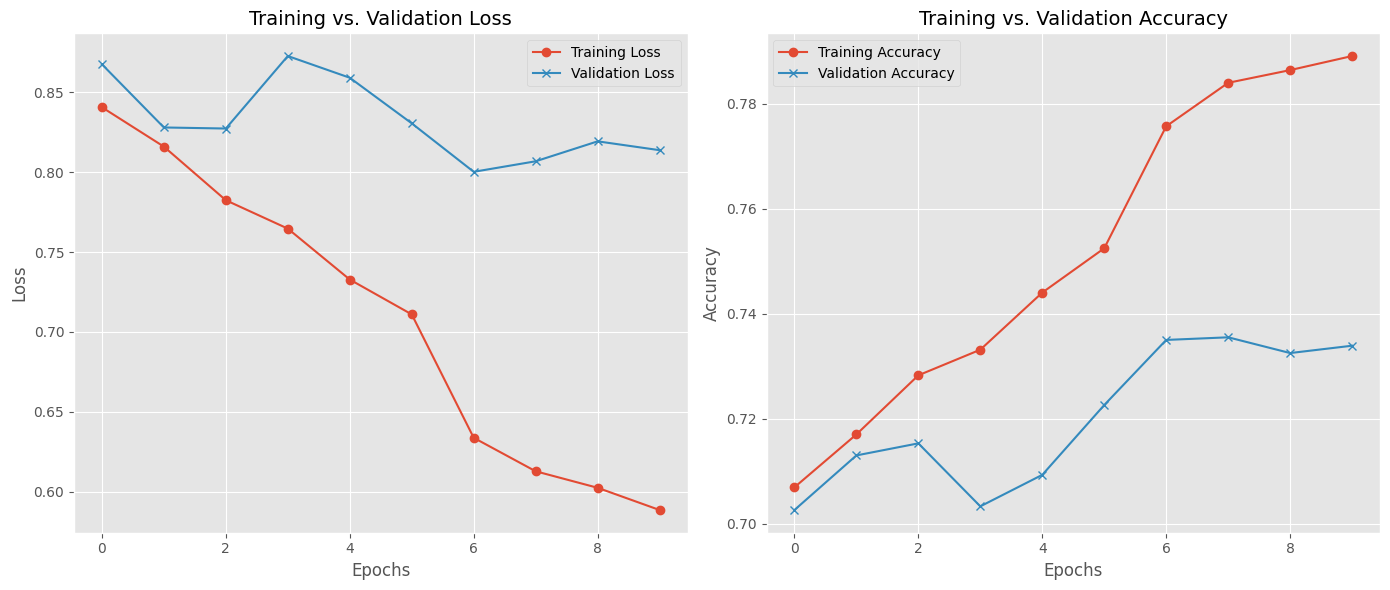

In [19]:
import matplotlib.pyplot as plt

# Optional: Use clean style
plt.style.use('ggplot')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Loss
axes[0].plot(history.history['loss'], label='Training Loss', marker='o')
axes[0].plot(history.history['val_loss'], label='Validation Loss', marker='x')
axes[0].set_title('Training vs. Validation Loss', fontsize=14)
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
axes[1].set_title('Training vs. Validation Accuracy', fontsize=14)
axes[1].set_xlabel('Epochs', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


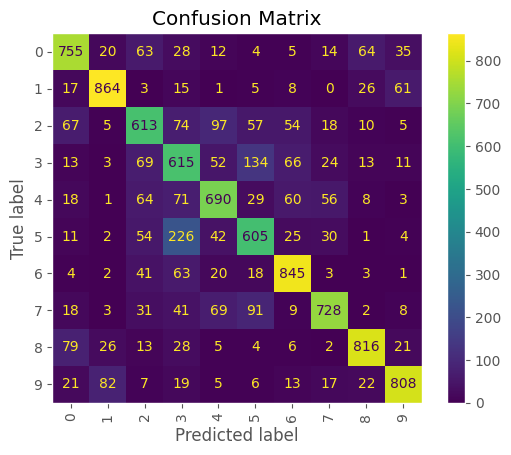

In [21]:
# Use the underlying Keras model to get probability predictions (if needed)
# Otherwise, directly use best_model.predict for class labels

# Option 1: If using raw Keras model and want probabilities
# y_prob = keras_model.predict(x_test)
# y_pred = np.argmax(y_prob, axis=1)

# Option 2: If using sklearn wrapper (GridSearchCV or RandomizedSearchCV)
y_pred = best_model.predict(x_test)  # Already returns class labels

# Now plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


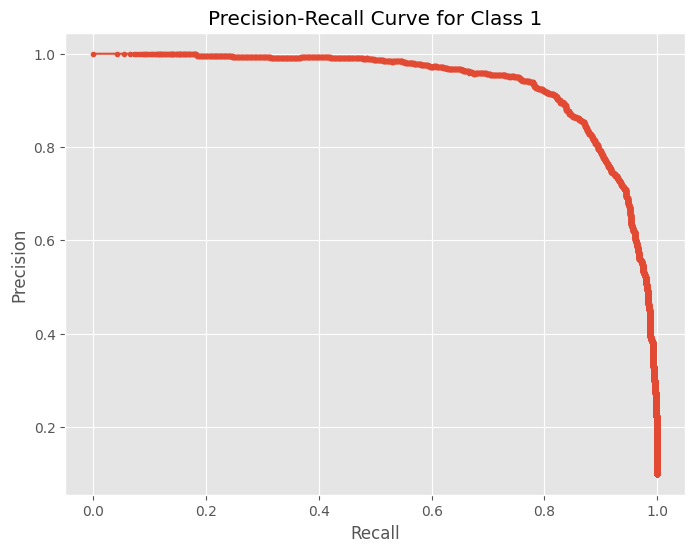

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# One-hot encode the true labels and predicted probabilities
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # shape: (n_samples, n_classes)
y_prob = keras_model.predict(x_test)  # shape: (n_samples, n_classes)

# Choose class 1 for example
class_idx = 1
precision, recall, _ = precision_recall_curve(y_test_bin[:, class_idx], y_prob[:, class_idx])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title(f'Precision-Recall Curve for Class {class_idx}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


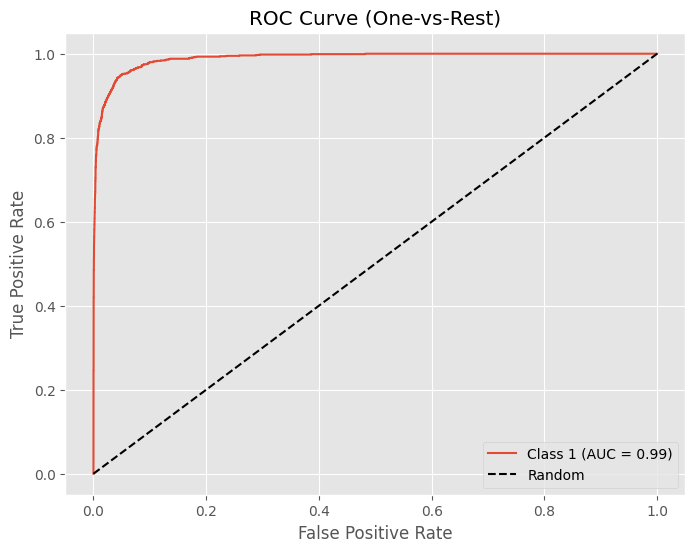

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Get probability predictions from Keras model
y_prob = keras_model.predict(x_test)  # shape (n_samples, n_classes)

# Binarize true labels (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # shape: (n_samples, n_classes)

# Choose a class index to plot (e.g. class 1)
class_idx = 1

# Compute ROC curve and AUC for class 1
fpr, tpr, _ = roc_curve(y_test_bin[:, class_idx], y_prob[:, class_idx])
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


Explanation of Key Steps Leading to Improved Model Performance:
Callback (ReduceLROnPlateau): By automatically reducing the learning rate when validation loss plateaus, the model is able to make finer adjustments and avoid overshooting the optimal solution.

Grid Search for Hyperparameter Optimization: By tuning the optimizer (Adam vs. SGD) and learning rate, we ensure that the model trains with the optimal settings, helping to achieve better accuracy and reduced validation loss.

Model Architecture: A convolutional neural network (CNN) was chosen to handle image data, where convolution layers extract important features from the images. Dropout was added to prevent overfitting.

Confusion Matrix: This visualization provided a clear understanding of which classes the model was misclassifying, helping to identify areas for improvement in future models.

Precision-Recall and ROC Curves: These visualizations provide more granular performance metrics, especially useful for understanding the model’s behavior for each class, beyond accuracy.